**imports**

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from classiq import *
from classiq.applications.iqae.iqae import IQAE
from classiq.open_library import amplitude_estimation

**Problem Setup and Parameters**

In [9]:
# -----------------------------
# Gaussian return model (1 year)
# -----------------------------
mu = 0.15         # mean return = 15%
sigma = 0.20      # std dev = 20%

# -----------------------------
# VaR confidence level (finance)
# -----------------------------
CONF_LEVEL = 0.95
ALPHA_VAR = 1 - CONF_LEVEL   # 0.05 for 95% VaR (left tail)

# -----------------------------
# Discretization resolution
# -----------------------------
num_qubits = 7               # grid size = 2^num_qubits points
N = 2**num_qubits

# Truncate Gaussian to finite interval so it fits on finite grid
L = 4
low = mu - L * sigma
high = mu + L * sigma

# Bisection stopping criterion (how close CDF must be to ALPHA_VAR)
TOLERANCE = ALPHA_VAR / 10

print("Grid points:", N)
print("Truncation interval:", (low, high))
print("VaR tail probability (finance):", ALPHA_VAR)
print("Bisection tolerance:", TOLERANCE)



Grid points: 128
Truncation interval: (-0.65, 0.9500000000000001)
VaR tail probability (finance): 0.050000000000000044
Bisection tolerance: 0.0050000000000000044


**Discretize Gaussian**

In [10]:
# Create the grid of possible return values (what each index means)
grid_points = np.linspace(low, high, N)

# Evaluate Gaussian PDF on the grid (unnormalized masses)
pdf_vals = stats.norm.pdf(grid_points, loc=mu, scale=sigma)

# Normalize to make it a probability distribution that sums to 1
probs = (pdf_vals / np.sum(pdf_vals)).tolist()

print("Sum(probs) =", sum(probs))

Sum(probs) = 0.9999999999999999


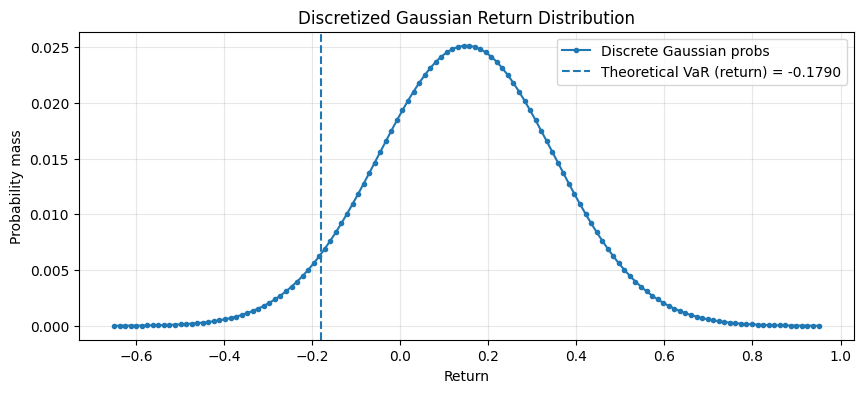

Theoretical VaR (return threshold): -0.17897072539029443
Theoretical VaR (as positive loss): 0.17897072539029443


In [11]:
# Theoretical (continuous) Gaussian VaR: 5th percentile of returns
var_theoretical = stats.norm.ppf(ALPHA_VAR, loc=mu, scale=sigma)

plt.figure(figsize=(10,4))
plt.plot(grid_points, probs, "o-", markersize=3, label="Discrete Gaussian probs")
plt.axvline(var_theoretical, linestyle="--", label=f"Theoretical VaR (return) = {var_theoretical:.4f}")
plt.title("Discretized Gaussian Return Distribution")
plt.xlabel("Return")
plt.ylabel("Probability mass")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("Theoretical VaR (return threshold):", var_theoretical)
print("Theoretical VaR (as positive loss):", -var_theoretical)

**Classical discrete VaR (for threshold)**

In [12]:
# find smallest idx where cumulative probability sum_{i<=idx} probs[i] >= ALPHA_VAR
acc = 0.0
VAR_scan = None
VAR_scan_idx = None

for idx, p in enumerate(probs):
    acc += p
    if acc >= ALPHA_VAR:
        VAR_scan = grid_points[idx]
        VAR_scan_idx = idx
        break

print(f"Discrete VaR (inclusive scan) index = {VAR_scan_idx}")
print(f"Discrete VaR (inclusive scan) return threshold = {VAR_scan}")
print(f"Discrete VaR (inclusive scan) as positive loss = {-VAR_scan}")


Discrete VaR (inclusive scan) index = 37
Discrete VaR (inclusive scan) return threshold = -0.1838582677165354
Discrete VaR (inclusive scan) as positive loss = 0.1838582677165354


**Classical bisection utilities (monotone search on index)**

In [13]:
def calc_alpha_classical_inclusive(index: int, probs: list[float]) -> float:
    """
    Inclusive left-tail CDF at grid index:
      alpha(index) = P(R <= grid_points[index]) ≈ sum_{i <= index} probs[i]
    """
    return sum(probs[:index+1])

def update_index(index: int, required_alpha: float, alpha_v: float, step: int) -> int:
    """
    If alpha_v is too small, we need to move right (increase index).
    If alpha_v is too big, move left (decrease index).
    """
    if alpha_v < required_alpha:
        return index + step
    return index - step

def get_initial_index() -> int:
    """Start somewhere not too extreme; quarter point like the Classiq notebook."""
    return N // 4

def value_at_risk_bisection(required_alpha: float, start_index: int, alpha_func):
    """
    Bisection over index (grid point) to solve:
      alpha_func(index) ≈ required_alpha
    """
    index = start_index
    step = max(1, index // 2)

    alpha_v = alpha_func(index)

    print("---- BISECTION START ----")
    print(f"start index={index}, return={grid_points[index]:.5f}, alpha={alpha_v:.5f}, step={step}")

    while (not np.isclose(alpha_v, required_alpha, atol=TOLERANCE)) and step > 0:
        index = update_index(index, required_alpha, alpha_v, step)

        # Keep index valid
        index = max(0, min(N-1, index))

        step //= 2
        alpha_v = alpha_func(index)
        print(f"index={index}, return={grid_points[index]:.5f}, alpha={alpha_v:.5f}, step={step}")

    print("---- BISECTION END ----")
    return index


**Run classical bisection**

In [14]:
start_idx = get_initial_index()
var_idx_bisect_classical = value_at_risk_bisection(
    ALPHA_VAR,
    start_idx,
    lambda i: calc_alpha_classical_inclusive(i, probs)
)

print("Bisection classical VaR index:", var_idx_bisect_classical)
print("Bisection classical VaR return:", grid_points[var_idx_bisect_classical])
print("Bisection classical VaR as positive loss:", -grid_points[var_idx_bisect_classical])


---- BISECTION START ----
start index=32, return=-0.24685, alpha=0.02538, step=16
index=48, return=-0.04528, alpha=0.17230, step=8
index=40, return=-0.14606, alpha=0.07364, step=4
index=36, return=-0.19646, alpha=0.04444, step=2
index=38, return=-0.17126, alpha=0.05760, step=1
index=37, return=-0.18386, alpha=0.05068, step=0
---- BISECTION END ----
Bisection classical VaR index: 37
Bisection classical VaR return: -0.1838582677165354
Bisection classical VaR as positive loss: 0.1838582677165354


**Quantum state prep: load distribution + mark tail event (oracle)**

In [15]:
# Global threshold index used by the oracle
GLOBAL_INDEX = 0

@qfunc
def load_distribution(asset: QNum):
    """
    Encodes the classical probs list into amplitudes:
      |psi> = sum_i sqrt(probs[i]) |i>
    """
    inplace_prepare_state(probs, bound=0, target=asset)

@qperm
def payoff(asset: Const[QNum], ind: QBit):
    """
    Inclusive tail event marker:
      ind ^= (asset <= GLOBAL_INDEX)

    After load_distribution + payoff:
      P(ind=1) = sum_{i <= GLOBAL_INDEX} probs[i]
    which is the inclusive CDF at GLOBAL_INDEX.
    """
    ind ^= asset <= GLOBAL_INDEX

@qfunc(synthesize_separately=True)
def state_preparation(asset: QNum, ind: QBit):
    """
    IQAE state preparation:
    1) load distribution in asset
    2) compute tail indicator into ind
    """
    load_distribution(asset)
    payoff(asset, ind)


**IQAE estimator**

In [16]:
written_qprog_iqae = False

def calc_alpha_iqae(index: int) -> float:
    """
    Uses IQAE to estimate inclusive CDF at index:
      alpha(index) = P(asset <= index)
    """
    global GLOBAL_INDEX, written_qprog_iqae
    GLOBAL_INDEX = index

    iqae = IQAE(
        state_prep_op=state_preparation,
        problem_vars_size=num_qubits,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=num_qubits),
    )

    if not written_qprog_iqae:
        written_qprog_iqae = True
        show(iqae.get_qprog())

    # epsilon = target absolute error on probability estimate
    # alpha   = failure probability (confidence = 1-alpha)
    iqae_res = iqae.run(epsilon=0.02, alpha=0.01)

    est = iqae_res.estimation
    ci = np.array([x for x in iqae_res.confidence_interval])

    print(f"IQAE at index={index}: alpha≈{est:.5f}, CI={ci}")
    return est


**Run IQAE + bisection**

In [17]:
start_idx = get_initial_index()

var_idx_iqae = value_at_risk_bisection(
    required_alpha=ALPHA_VAR,
    start_index=start_idx,
    alpha_func=calc_alpha_iqae
)

print("\n=== IQAE RESULTS ===")
print("IQAE VaR index:", var_idx_iqae)
print("IQAE VaR return threshold:", grid_points[var_idx_iqae])
print("IQAE VaR as positive loss:", -grid_points[var_idx_iqae])


Quantum program link: https://platform.classiq.io/circuit/394En6ADOhDQnLourl5ORzgHzBm
IQAE at index=32: alpha≈0.02457, CI=[0.02202399 0.02710866]
---- BISECTION START ----
start index=32, return=-0.24685, alpha=0.02457, step=16
IQAE at index=48: alpha≈0.17164, CI=[0.16814385 0.17512893]
index=48, return=-0.04528, alpha=0.17164, step=8
IQAE at index=40: alpha≈0.07704, CI=[0.0696896  0.08438804]
index=40, return=-0.14606, alpha=0.07704, step=4
IQAE at index=36: alpha≈0.04469, CI=[0.04069011 0.04869319]
index=36, return=-0.19646, alpha=0.04469, step=2
IQAE at index=38: alpha≈0.05759, CI=[0.05117278 0.06401539]
index=38, return=-0.17126, alpha=0.05759, step=1
IQAE at index=37: alpha≈0.04811, CI=[0.04207103 0.05414502]
index=37, return=-0.18386, alpha=0.04811, step=0
---- BISECTION END ----

=== IQAE RESULTS ===
IQAE VaR index: 37
IQAE VaR return threshold: -0.1838582677165354
IQAE VaR as positive loss: 0.1838582677165354


**Final comparison summary**

In [67]:
print("\n=== FINAL COMPARISON ===")
print("Inclusive scan VaR index:", VAR_scan_idx)
print("Inclusive scan VaR return:", VAR_scan)

print("Classical bisection VaR index:", var_idx_bisect_classical)
print("Classical bisection VaR return:", grid_points[var_idx_bisect_classical])

print("IQAE VaR index:", var_idx_iqae)
print("IQAE VaR return:", grid_points[var_idx_iqae])


print("Theoretical continuous Gaussian VaR return:", var_theoretical)



=== FINAL COMPARISON ===
Inclusive scan VaR index: 37
Inclusive scan VaR return: -0.1838582677165354
Classical bisection VaR index: 37
Classical bisection VaR return: -0.1838582677165354
IQAE VaR index: 37
IQAE VaR return: -0.1838582677165354
Theoretical continuous Gaussian VaR return: -0.17897072539029443
